## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

# 1. Camera calibration

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# make a list of calibration images
image_fnames = glob.glob('camera_cal/calibration*.jpg')

# load the images
images = [cv2.imread(fname) for fname in image_fnames]

In [3]:
# step through the list and search for chessboard corners

images_with_corners = list()
for image in images:
    img = image.copy() # copy to avoid reference issues
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # if found, add object points, image points
    if ret:
        objpoints.append(objp)
        imgpoints.append(corners)

        # draw the corners on the original image
        img_corners = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        images_with_corners.append(img_corners)
        
print('Correctly found corners in %i images of %i' % (len(images_with_corners),len(images)))

Correctly found corners in 17 images of 20


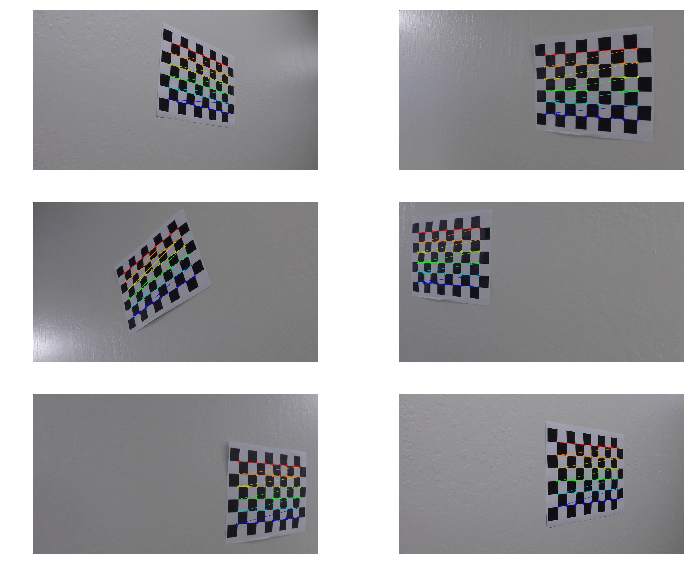

In [4]:
# plot random subset of calibration images including highlighted corners
f, axes = plt.subplots(3,2, figsize=(12,10))
axes = axes.flatten()
plot_random_subset = np.random.choice(images_with_corners, size=6, replace=False)
for i in range(plot_random_subset.shape[0]):
    axes[i].imshow(
        cv2.cvtColor(plot_random_subset[i], cv2.COLOR_BGR2RGB))
    axes[i].axis('off')

In [5]:
# camera calibration, given object points, image points, and the shape of the grayscale image:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

# encapsulate camera calibration parameters in dictionary
camera_params = {
    'ret': ret,
    'mtx': mtx,
    'dist': dist,
    'rvecs': rvecs,
    'tvecs': tvecs
}

In [6]:
# undistort the calibration images
undistorted_images = list()
for img in images:
    undistorted_images.append(cv2.undistort(img, mtx, dist, None, mtx))

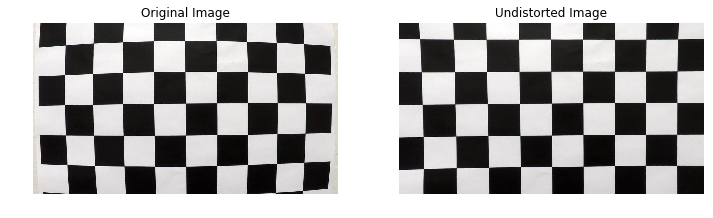

In [7]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,10))
ax1.imshow(
    cv2.cvtColor(images[0], cv2.COLOR_BGR2RGB))
ax1.axis('off')
ax2.imshow(
    cv2.cvtColor(undistorted_images[0], cv2.COLOR_BGR2RGB))
ax2.axis('off')
ax1.set_title('Original Image')
ax2.set_title('Undistorted Image');

# 2. Pipeline

## 2.1. Distortion correction

In [8]:
from aux_fun import undistort

In [9]:
# load test image
test_img = cv2.cvtColor(cv2.imread('test_images/test7.jpg'), cv2.COLOR_BGR2RGB)

# undistort test image
undist_test_img = undistort(test_img, camera_params)

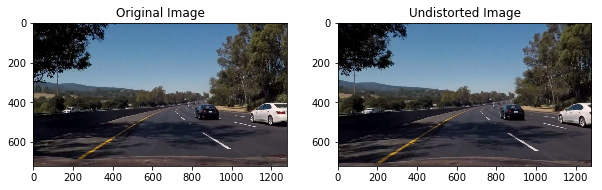

In [10]:
# plot comparison between original and undistorted images
f, axes = plt.subplots(1,2, figsize=(10,10))
axes = axes.flatten()
axes[0].imshow(test_img)
#axes[0].axis('off')
axes[0].set_title('Original Image')
axes[1].imshow(undist_test_img)
#axes[1].axis('off')
axes[1].set_title('Undistorted Image');

## 2.2. Thresholding

In [11]:
from aux_fun import plot_3_channels
from aux_fun import abs_sobel_thresh, sobel_magnitude_thresh, dir_threshold, color_channel_thresh

In [12]:
test_gray = cv2.cvtColor(undist_test_img, cv2.COLOR_RGB2GRAY)
test_hsv = cv2.cvtColor(undist_test_img, cv2.COLOR_RGB2HSV)
test_hls = cv2.cvtColor(undist_test_img, cv2.COLOR_RGB2HLS)
test_lab = cv2.cvtColor(undist_test_img, cv2.COLOR_RGB2LAB)
test_luv = cv2.cvtColor(undist_test_img, cv2.COLOR_RGB2LUV)
test_yuv = cv2.cvtColor(undist_test_img, cv2.COLOR_RGB2YUV)

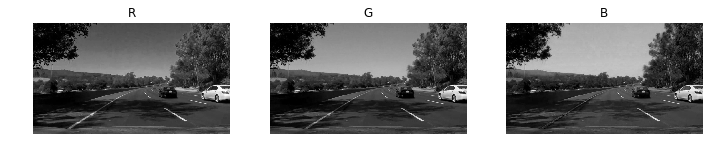

In [13]:
plot_3_channels(test_img, ('R', 'G', 'B'))

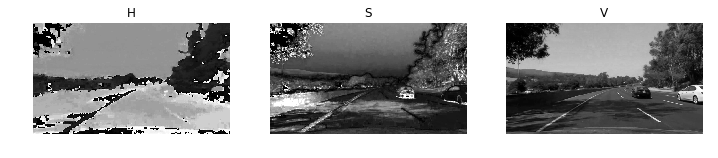

In [14]:
plot_3_channels(test_hsv, ('H', 'S', 'V'))

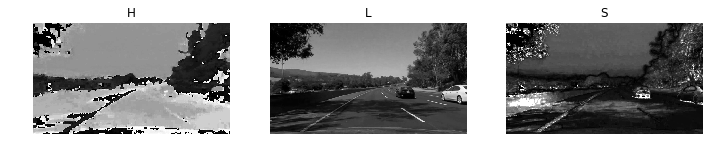

In [15]:
plot_3_channels(test_hls, ('H', 'L', 'S'))

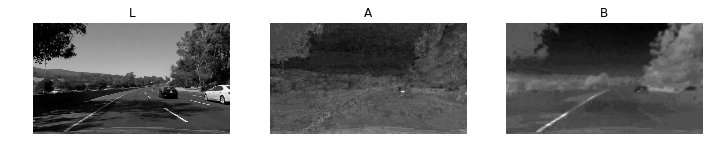

In [16]:
plot_3_channels(test_lab, ('L', 'A', 'B'))

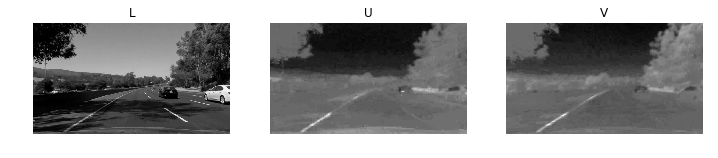

In [17]:
plot_3_channels(test_luv, ('L', 'U', 'V'))

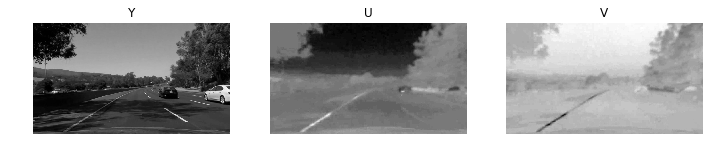

In [18]:
plot_3_channels(test_yuv, ('Y', 'U','V'))

In [19]:
r_ch, g_ch, b_ch = undist_test_img[:,:,0], undist_test_img[:,:,1], undist_test_img[:,:,2] 
h_ch, l_ch, s_ch = test_hls[:,:,0], test_hls[:,:,1], test_hls[:,:,2]
y_ch, u_ch, v_ch = test_yuv[:,:,0], test_yuv[:,:,1], test_yuv[:,:,2] 
L_ch, a_ch, B_ch = test_lab[:,:,0], test_lab[:,:,1], test_lab[:,:,2] 

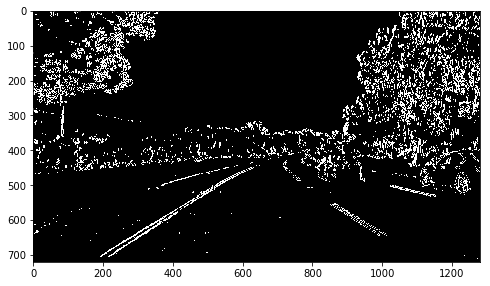

In [20]:
plt.figure(figsize=(8,8))
plt.imshow(abs_sobel_thresh(L_ch, orient='x', sobel_kernel=7, thresh=(20, 70)), cmap='gray');

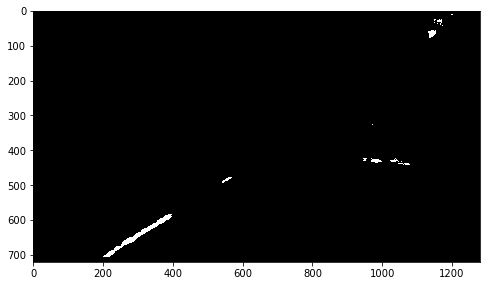

In [21]:
plt.figure(figsize=(8,8))
plt.imshow(color_channel_thresh(B_ch, thresh=(150, 255)), cmap='gray');

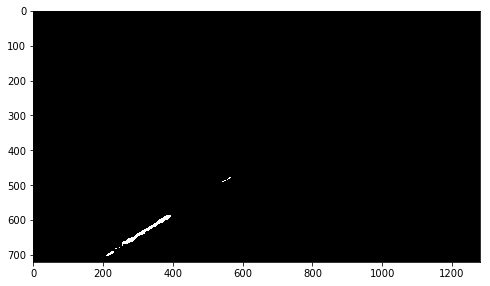

In [22]:
plt.figure(figsize=(8,8))
plt.imshow(color_channel_thresh(v_ch, thresh=(0, 100)), cmap='gray');

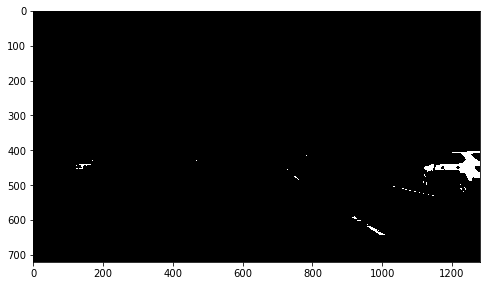

In [23]:
plt.figure(figsize=(8,8))
plt.imshow(color_channel_thresh(y_ch, thresh=(200, 255)), cmap='gray');

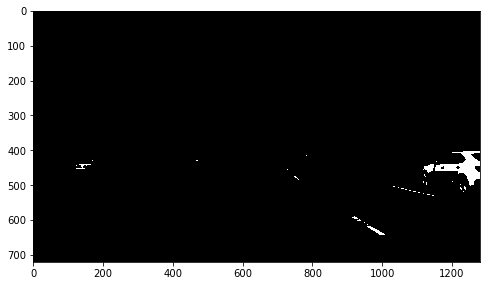

In [24]:
plt.figure(figsize=(8,8))
plt.imshow(color_channel_thresh(L_ch, thresh=(200, 255)), cmap='gray');

L and b from Lab behave very similar to Y and V from YUV.

In [25]:
def thresholding_pipeline(img_rgb):
    lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2LAB)
    L_ch, a_ch, B_ch = lab[:,:,0], lab[:,:,1], lab[:,:,2] 
    
    L_sobelx_bin = abs_sobel_thresh(L_ch, orient='x', sobel_kernel=7, thresh=(20, 70))
    B_bin = color_channel_thresh(B_ch, thresh=(150, 255))
    L_bin = color_channel_thresh(L_ch, thresh=(200, 255))
    
    bin_res = B_bin | L_bin | L_sobelx_bin
    return bin_res

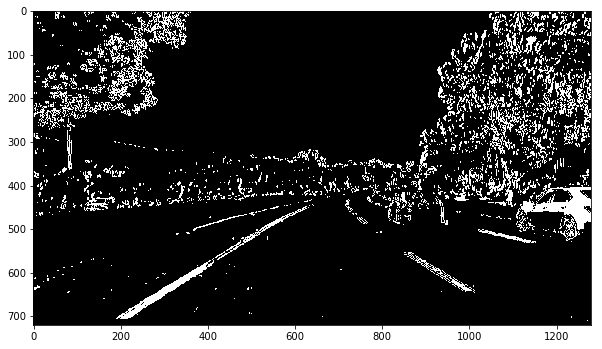

In [26]:
binary_img = thresholding_pipeline(undist_test_img)
plt.figure(figsize=(10,10))
plt.imshow(
    binary_img,
    cmap='gray'
);

## 2.3. Perspective transform

In [27]:
from aux_fun import draw_polygon_on_image_inplace
from aux_fun import warp_image

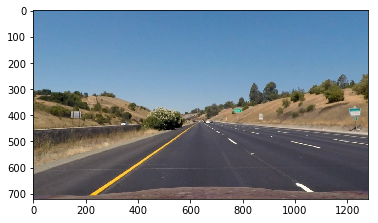

In [28]:
# load test image
warp_ref_img = cv2.cvtColor(cv2.imread('test_images/straight_lines1.jpg'), cv2.COLOR_BGR2RGB)

# undistort test image
undist_warp_ref_img = undistort(warp_ref_img, camera_params)
plt.imshow(undist_warp_ref_img);

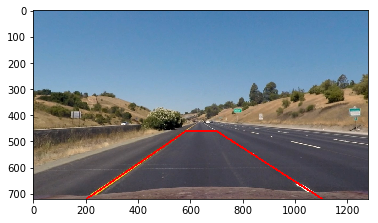

In [29]:
test_poly = np.copy(undist_warp_ref_img)
img_size = test_poly.shape[:2]
src_vertices = np.float32(
    [
        [img_size[1] / 6 - 10, img_size[0]],
        [img_size[1] / 2 - 55, img_size[0] / 2 + 100],
        [img_size[1] / 2 + 60, img_size[0] / 2 + 100],
        [img_size[1] * 5 / 6 + 40, img_size[0]]
    ]
)
draw_polygon_on_image_inplace(test_poly, src_vertices)
plt.imshow(test_poly);

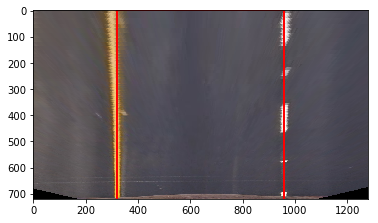

In [30]:
dst_vertices = np.float32(
    [
        [img_size[1] / 4, img_size[0]],
        [img_size[1] / 4, 0],
        [img_size[1] * 3 / 4, 0],
        [img_size[1] * 3 / 4, img_size[0]]
    ]
)
test_warped = warp_image(undist_warp_ref_img, src_vertices, dst_vertices)
draw_polygon_on_image_inplace(test_warped, dst_vertices)
plt.imshow(test_warped);

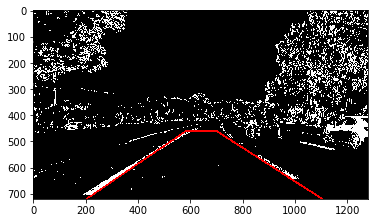

In [31]:
binary_img_copy = np.dstack((binary_img*255,)*3)
draw_polygon_on_image_inplace(binary_img_copy, src_vertices)
plt.imshow(binary_img_copy);

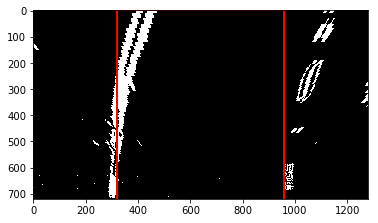

In [32]:
warped_binary_img = warp_image(binary_img, src_vertices, dst_vertices)
warped_binary_img_copy = np.dstack((warped_binary_img*255,)*3)
draw_polygon_on_image_inplace(warped_binary_img_copy, dst_vertices)
plt.imshow(warped_binary_img_copy);

## 2.4. Lane detection

In [33]:
from aux_fun import find_lanes_sliding_window_hist, find_lanes_near_previous, get_lane_fit_coeffs

In [34]:
binary_warped = np.copy(warped_binary_img)

In [35]:
leftx, lefty, rightx, righty, out_img = find_lanes_sliding_window_hist(
    binary_warped, 
    minpix=50,
    get_viz=True)
left_fit, right_fit = get_lane_fit_coeffs(leftx, lefty, rightx, righty)

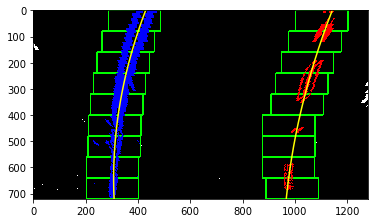

In [36]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0);

In [37]:
margin=100
leftx_new, lefty_new, rightx_new, righty_new, out_img_new = find_lanes_near_previous(
    binary_warped,
    left_fit,
    right_fit,
    margin=margin,
    get_viz=True
)

left_fit_new, right_fit_new = get_lane_fit_coeffs(leftx_new, lefty_new, rightx_new, righty_new)

In [38]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx_new = left_fit_new[0]*ploty**2 + left_fit_new[1]*ploty + left_fit_new[2]
right_fitx_new = right_fit_new[0]*ploty**2 + right_fit_new[1]*ploty + right_fit_new[2]

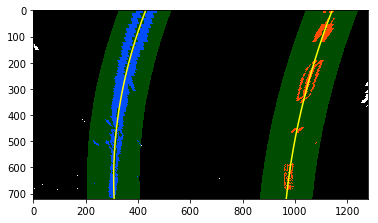

In [39]:
window_img = np.zeros_like(out_img_new)
# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img_new, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx_new, ploty, color='yellow')
plt.plot(right_fitx_new, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0);

## 2.5. Curvature and offset calculation

In [40]:
from aux_fun import calculate_radius_in_meters, calculate_offset_in_meters

In [41]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
r_left = calculate_radius_in_meters(y_eval, left_fit, 3.7/700, 30/720)
r_right = calculate_radius_in_meters(y_eval, right_fit, 3.7/700, 30/720)
offset = calculate_offset_in_meters(warped_binary_img, left_fit, right_fit, 3.7/700)

## 2.6 Output display

In [42]:
from aux_fun import print_summary_on_original_image

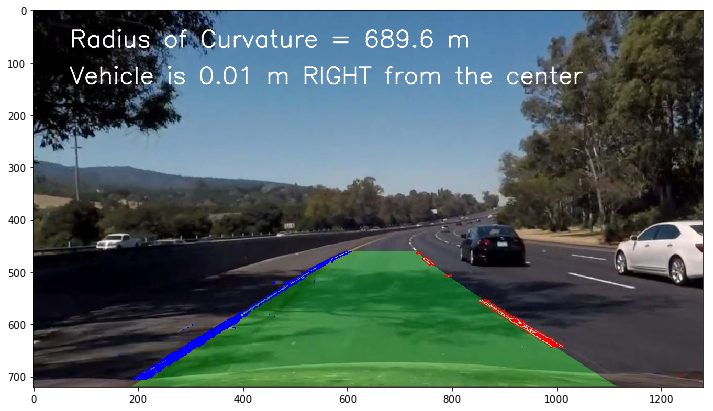

In [43]:
result = print_summary_on_original_image(
    undist_test_img, binary_warped,
    left_fitx, right_fitx, ploty,
    leftx, lefty, rightx, righty,
    r_left, r_right, offset,
    src_vertices, dst_vertices
)
plt.figure(figsize=(12, 12))
plt.imshow(result);

# 3. Encapsulate pipeline

In [44]:
class Line():
    def __init__(self):
        self.previous_fit_coeffs = None

In [45]:
def pipeline(original_img_rgb, thr_pipeline, l_lane, r_lane, camera_params, src_vertices, dst_vertices):
    undist_img = undistort(original_img_rgb, camera_params)
    binary_img = thr_pipeline(undist_img)
    binary_warped = warp_image(binary_img, src_vertices, dst_vertices)
    
    if (l_lane.previous_fit_coeffs is None) or (l_lane.previous_fit_coeffs is None):
        leftx, lefty, rightx, righty, _ = find_lanes_sliding_window_hist(binary_warped, get_viz=False)
    else:
        leftx, lefty, rightx, righty, _ = find_lanes_near_previous(
            binary_warped,
            l_lane.previous_fit_coeffs,
            r_lane.previous_fit_coeffs,
            get_viz=False)
        
    left_fit, right_fit = get_lane_fit_coeffs(leftx, lefty, rightx, righty)
    l_lane.previous_fit_coeffs = left_fit
    r_lane.previous_fit_coeffs = right_fit
    
    y_eval = binary_warped.shape[0]
    r_left = calculate_radius_in_meters(y_eval, left_fit, 3.7/700, 30/720)
    r_right = calculate_radius_in_meters(y_eval, right_fit, 3.7/700, 30/720)
    
    offset = calculate_offset_in_meters(binary_warped, left_fit, right_fit, 3.7/700)
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    res = print_summary_on_original_image(
        undist_img, binary_warped,
        left_fitx, right_fitx, ploty,
        leftx, lefty, rightx, righty,
        r_left, r_right, offset,
        src_vertices, dst_vertices
    )
    return res

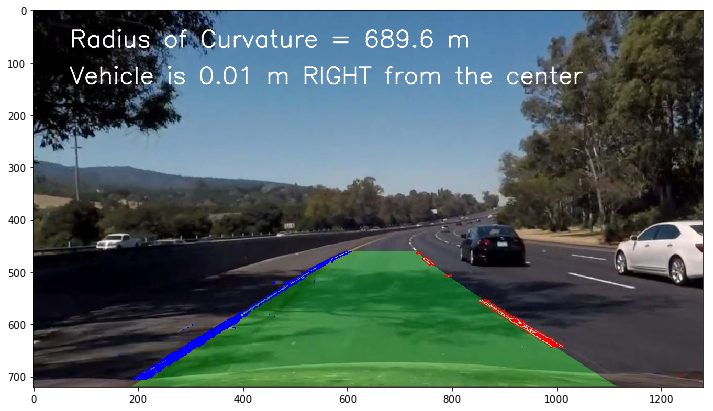

In [46]:
l_lane = Line()
r_lane = Line()
plt.figure(figsize=(12, 12))
plt.imshow(
    pipeline(test_img, thresholding_pipeline, l_lane, r_lane, camera_params, src_vertices, dst_vertices));

# 4. Video

In [47]:
from moviepy.editor import VideoFileClip

In [48]:
l_lane = Line()
r_lane = Line()
frame_pl = lambda frame: pipeline(
    frame, thresholding_pipeline, l_lane, r_lane, camera_params, src_vertices, dst_vertices
)
build_video = True
if build_video:
    test_output = 'project_video_solution.mp4'
    clip = VideoFileClip("project_video.mp4")
    test_clip = clip.fl_image(frame_pl)
    %time test_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video project_video_solution.mp4
[MoviePy] Writing video project_video_solution.mp4


100%|█████████▉| 1260/1261 [02:04<00:00, 10.00it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_solution.mp4 

Wall time: 2min 5s
